# Leer datasets

In [7]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
glass = fetch_ucirepo(id=42) 

glass = glass.data.features 
#drop null values
glass = glass.dropna()
print(glass.shape)
glass.head()

(214, 9)


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0


# Realizamos los clusters

In [8]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, SpectralClustering, AffinityPropagation, Birch, OPTICS, BisectingKMeans
from sklearn.mixture import GaussianMixture
n_clusters = 6
clustering_algorithms = {
    'KMeans': KMeans(n_clusters=n_clusters, random_state=42),
    'DBSCAN': DBSCAN(eps=0.7, min_samples=5),
    'AgglomerativeClustering': AgglomerativeClustering(n_clusters=n_clusters),
    'MeanShift': MeanShift(),
    'SpectralClustering': SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors'),
    'AffinityPropagation': AffinityPropagation(),
    'Birch': Birch(n_clusters=n_clusters),
    'OPTICS': OPTICS(min_samples=5, cluster_method='xi', xi=0.05),
    'BisectingKMeans': BisectingKMeans(n_clusters=n_clusters, random_state=42),
    'GaussianMixture': GaussianMixture(n_components=n_clusters, random_state=42)
}
results = {}
for name, algorithm in clustering_algorithms.items():
    try:
        algorithm.fit(glass)
        if hasattr(algorithm, 'labels_'):
            labels = algorithm.labels_
        elif hasattr(algorithm, 'predict'):
            labels = algorithm.predict(glass)
        else:
            labels = algorithm.means_.argmax(axis=0)  # For GaussianMixture
        results[name] = labels
    except Exception as e:
        print(f"Error with {name}: {e}")

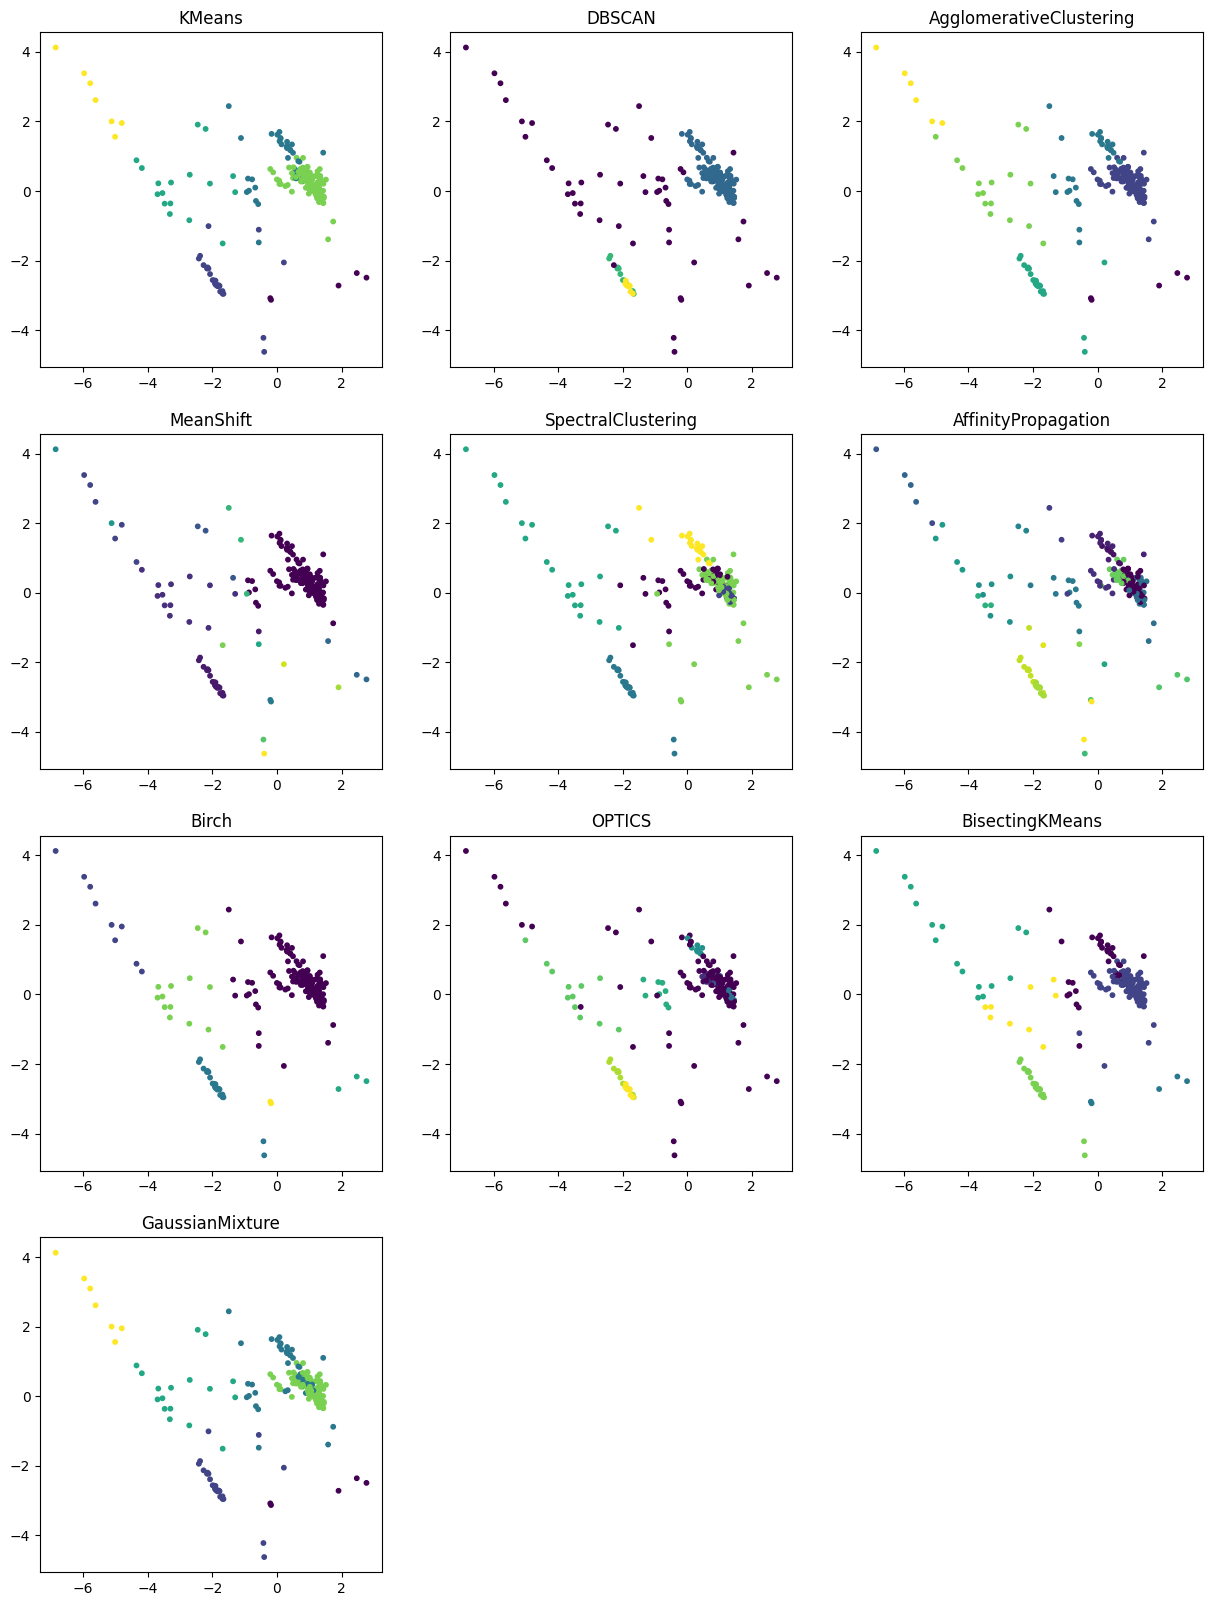

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
glass_pca = pca.fit_transform(glass)
plt.figure(figsize=(15, 20))
for i, (name, labels) in enumerate(results.items(), 1):
    plt.subplot(4, 3, i)
    plt.scatter(glass_pca[:, 0], glass_pca[:, 1], c=labels, cmap='viridis', s=10)
    plt.title(name)

In [10]:
#definimos dunn index
def dunn_index(data, labels):
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return 0.0

    inter_cluster_distances = []
    intra_cluster_distances = []

    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            cluster_i = data[labels == unique_labels[i]]
            cluster_j = data[labels == unique_labels[j]]
            inter_distance = np.linalg.norm(cluster_i.mean(axis=0) - cluster_j.mean(axis=0))
            inter_cluster_distances.append(inter_distance)

        intra_distance = np.mean([np.linalg.norm(data[labels == unique_label] - data[labels == unique_label].mean(axis=0)) for unique_label in unique_labels])
        intra_cluster_distances.append(intra_distance)

    dunn_index_value = min(inter_cluster_distances) / max(intra_cluster_distances)
    return dunn_index_value

In [11]:
#podrias generar una metrica en que se calcule el valor maximo de distancia (entre las menores distancias de cada punto con otro dentro del mismo cluster) dividido por el valor minimo de distancia entre cualquier punto de un cluster con otro punto de otro cluster
import numpy as np
from sklearn.metrics import pairwise_distances

def custom_metric(X, labels):
    X = np.array(X)
    distances = pairwise_distances(X)
    n = len(X)
    
    # Numerador: máximo de las mínimas distancias dentro del mismo cluster
    max_min_intra = -np.inf
    for i in range(n):
        same_cluster = (labels == labels[i])
        same_cluster[i] = False  # Exclude itself
        if np.any(same_cluster):
            min_dist = np.min(distances[i][same_cluster])
            max_min_intra = max(max_min_intra, min_dist)
    
    # Denominador: mínima distancia entre puntos de distintos clusters
    min_inter = np.inf
    for i in range(n):
        other_cluster = (labels != labels[i])
        if np.any(other_cluster):
            min_dist = np.min(distances[i][other_cluster])
            min_inter = min(min_inter, min_dist)

    M = max_min_intra / min_inter if min_inter != 0 else np.inf
    return 1 /( 1 + M)


In [12]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from permetrics import ClusteringMetric
def evaluate_clustering(data, labels):
    if len(set(labels)) < 2:
        return {
            'Silhouette Score': None,
            'Calinski-Harabasz Score': None,
            'Davies-Bouldin Score': None,
            'Dunn Index': None,
            'custom_metric': None,
            'dbcv': None
        }
    
    silhouette = silhouette_score(data, labels)
    calinski_harabasz = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    dunn = dunn_index(data.values, labels)
    custom = custom_metric(data.values, labels)
    dbcv = ClusteringMetric(X=data.values, y_pred=labels).DBCVI()

    return {
        'Silhouette Score': silhouette,
        'Calinski-Harabasz Score': calinski_harabasz,
        'Davies-Bouldin Score': davies_bouldin,
        'Dunn Index': dunn,
        'custom_metric': custom,
        'dbcv': dbcv
    }
evaluation_results = {}
for name, labels in results.items():
    evaluation_results[name] = evaluate_clustering(glass, labels)
evaluation_df = pd.DataFrame(evaluation_results).T
evaluation_df = evaluation_df.rename(columns={
    'Silhouette Score': 'Silhouette',
    'Calinski-Harabasz Score': 'Calinski-Harabasz',
    'Davies-Bouldin Score': 'Davies-Bouldin',
    'Dunn Index': 'Dunn',
    'custom_metric': 'Custom Metric'
})
evaluation_df

/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Dunn,Custom Metric,dbcv
KMeans,0.448291,124.501447,0.967296,0.240735,0.043849,0.935693
DBSCAN,0.459371,45.050735,1.416482,0.117955,0.140101,NaN
AgglomerativeClustering,0.462192,118.711158,0.981729,0.242202,0.128723,0.927699
MeanShift,0.471984,60.916788,0.562469,1.169807,0.123660,0.966921
SpectralClustering,0.098913,70.235481,1.330378,0.116826,0.052360,0.971135
AffinityPropagation,0.263863,73.492935,0.980716,0.448892,0.031106,0.988536
Birch,0.573214,100.318156,0.781873,0.476887,0.233936,0.901395
OPTICS,-0.177666,15.445016,1.759378,0.135674,0.046809,NaN
BisectingKMeans,0.421891,109.174927,1.163635,0.231448,0.068798,0.938674
GaussianMixture,0.380043,113.706438,1.088814,0.186994,0.059679,0.975467


In [13]:
#elige los mejores 3 resultados ponderando el orden de cada métrica
def weighted_score(row):
    weights = {
        'Silhouette': 0.2,
        'Calinski-Harabasz': -0.2,
        'Davies-Bouldin': 0.2,  # Negativo porque queremos minimizar
        'Dunn': 0.2,
        'Custom Metric': 0.5 # Puedes ajustar este peso según su importancia
    }
    score = (row['Silhouette'] * weights['Silhouette'] +
                1/(1+row['Calinski-Harabasz']) * weights['Calinski-Harabasz'] +
                1/(1+row['Davies-Bouldin']) * weights['Davies-Bouldin'] +
                row['Dunn'] * weights['Dunn'] +
                row['Custom Metric'] * weights['Custom Metric'])
    return score
# Replace None values with 0 for scoring
evaluation_df_filled = evaluation_df.fillna(0)
evaluation_df_filled['Weighted Score'] = evaluation_df_filled.apply(weighted_score, axis=1)
top_3_algorithms = evaluation_df_filled.nlargest(3, 'Weighted Score')
top_3_algorithms

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Dunn,Custom Metric,dbcv,Weighted Score
MeanShift,0.471984,60.916788,0.562469,1.169807,0.123660,0.966921,0.514961
Birch,0.573214,100.318156,0.781873,0.476887,0.233936,0.901395,0.437256
AgglomerativeClustering,0.462192,118.711158,0.981729,0.242202,0.128723,0.927699,0.304491


# Interpretar

In [14]:
import sys
sys.path.append('../..')
from ripper import MultiClassRipperClassifier
from dsgd import DSClassifierMultiQ
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree as sk_tree

In [15]:
# interpretamos solo los mejores 3 resultados y guardamos los modelos
saved_models = {}
top_3_labels = {name: results[name] for name in top_3_algorithms.index}
top_3_data = glass.copy()
for name, labels in top_3_labels.items():
    n = len(np.unique(labels))
    X_train, X_test, y_train, y_test = train_test_split(top_3_data, labels, test_size=0.2, random_state=42)
    print(f'Processing {name} with {n} clusters')
    
    # Ripper
    ripper = MultiClassRipperClassifier(random_state=43)
    ripper.fit(X_train, y_train)
    y_pred_ripper = ripper.predict(X_test)
    print(f'Ripper Accuracy for {name}: {accuracy_score(y_test, y_pred_ripper):.2f}')
    saved_models.setdefault(name, {})['ripper'] = ripper
    
    # Decision Tree
    dtree = DecisionTreeClassifier(random_state=42, max_depth=5)
    dtree.fit(X_train, y_train)
    dtree_pred = dtree.predict(X_test)
    print(f'Decision Tree Accuracy for {name}: {accuracy_score(y_test, dtree_pred):.2f}')
    saved_models[name]['dtree'] = dtree
    
    # DSGD
    ds = DSClassifierMultiQ(n, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
    X = X_train.to_numpy()
    losses, epoch, dt = ds.fit(X, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=X_train.columns)
    x_test = X_test.to_numpy()
    y_pred_ds = ds.predict(x_test)
    print(f'DSGD Accuracy for {name}: {accuracy_score(y_test, y_pred_ds):.2f}')
    saved_models[name]['ds'] = ds
    
    print('--' * 40)


Processing MeanShift with 16 clusters


ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset i

Ripper Accuracy for MeanShift: 0.84
Decision Tree Accuracy for MeanShift: 0.91
Optimization started

Training time: 3.97s, epochs: 100

Least training loss reached: 0.005
DSGD Accuracy for MeanShift: 0.93
--------------------------------------------------------------------------------
Processing Birch with 6 clusters


ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.



Ripper Accuracy for Birch: 0.91
Decision Tree Accuracy for Birch: 0.98
Optimization started

Training time: 5.53s, epochs: 166

Least training loss reached: 0.006
DSGD Accuracy for Birch: 0.91
--------------------------------------------------------------------------------
Processing AgglomerativeClustering with 6 clusters
Ripper Accuracy for AgglomerativeClustering: 0.86
Decision Tree Accuracy for AgglomerativeClustering: 0.88
Optimization started

Training time: 5.78s, epochs: 170

Least training loss reached: 0.005
DSGD Accuracy for AgglomerativeClustering: 0.95
--------------------------------------------------------------------------------


# Primer algoritmo

In [16]:
#interpretamos primer algoritmo
models = saved_models[top_3_algorithms.index[0]]
print('Ripper Rules:')
models['ripper'].print_rules()

Ripper Rules:

Reglas para clase: 0
[[Ba=<0.56^K=0.52-0.56] V [Ba=<0.56^RI=1.5174-1.5178] V [Ba=<0.56^K=0.62-0.68] V [Ba=<0.56^Mg=3.15-3.43] V [Ba=<0.56^Mg=>3.8] V [Ba=<0.56^Mg=3.66-3.8] V [Mg=3.43-3.49] V [Mg=3.49-3.54] V [Mg=3.54-3.58] V [Mg=3.58-3.66] V [Mg=1.74-3.15^Ca=9.02-9.57] V [Al=1.35-1.44^Mg=1.74-3.15]]

Reglas para clase: 1
[[Mg=<1.74^Ba=>0.56] V [Al=>1.98^K=<0.11]]

Reglas para clase: 2
[[Mg=<1.74^RI=1.5187-1.5206] V [Ca=>10.09]]

Reglas para clase: 3
[[Ca=>10.09]]

Reglas para clase: 4
[[Na=<12.72^RI=1.5206-1.5221]]

Reglas para clase: 5
[[Mg=3.15-3.43^Na=13.99-14.38]]

Reglas para clase: 6
[]

Reglas para clase: 7
[]

Reglas para clase: 8
[]

Reglas para clase: 9
[]

Reglas para clase: 10
[[Mg=1.74-3.15^Al=<0.87]]

Reglas para clase: 11
[]

Reglas para clase: 12
[]

Reglas para clase: 13
[]

Reglas para clase: 14
[]


Decision Tree:


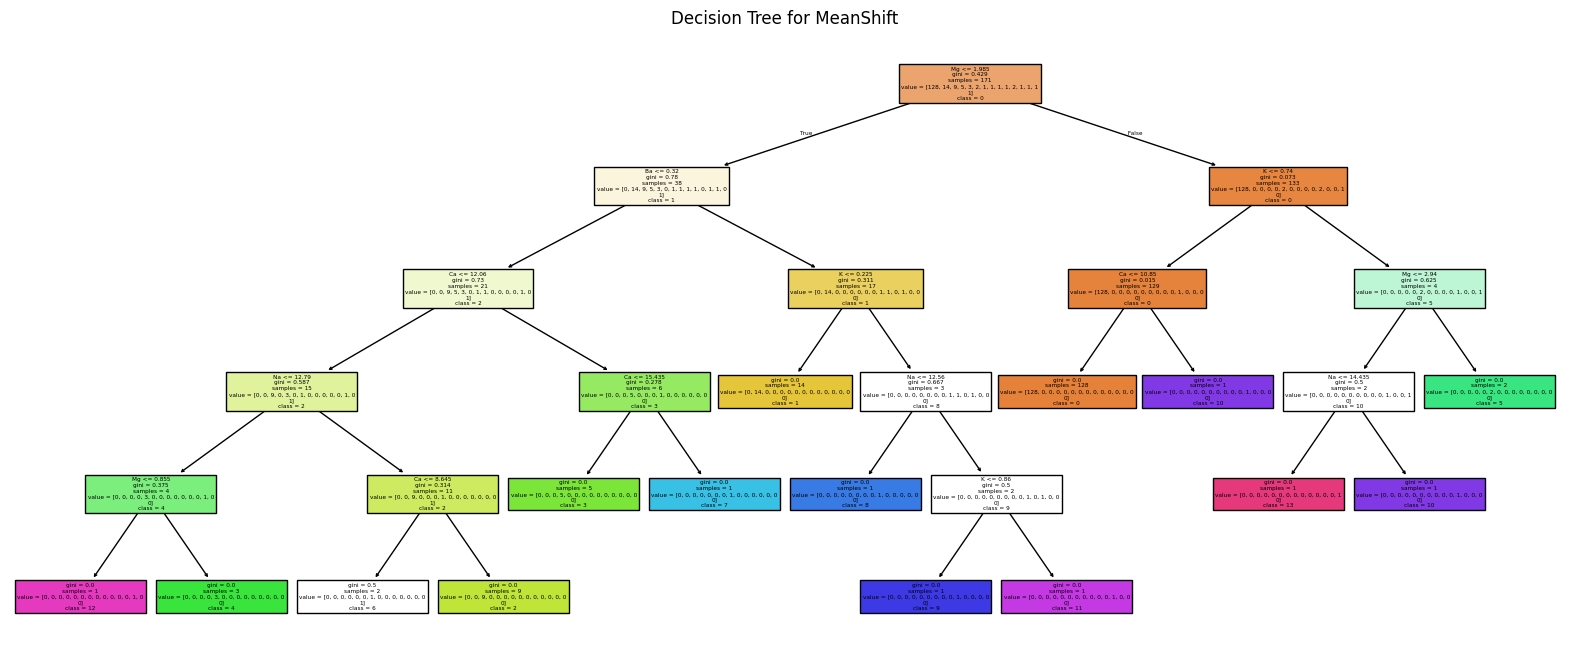

In [17]:
print('Decision Tree:')
plt.figure(figsize=(20, 8))
sk_tree.plot_tree(models['dtree'], filled=True, feature_names=glass.columns, class_names=np.unique(top_3_labels[top_3_algorithms.index[0]]).astype(str))
plt.title(f'Decision Tree for {top_3_algorithms.index[0]}')
plt.show()

In [18]:
print('DSGD Rules:')
models['ds'].print_most_important_rules(threshold=0.1)
print('--' * 40)

DSGD Rules:


Most important rules for class 0

	[0.517] R0: RI < 1.516
			0: 0.332	1: 0.235	2: 0.000	3: 0.000	4: 0.000	5: 0.000	6: 0.144	7: 0.000	8: 0.000	9: 0.000	10: 0.000	11: 0.000	12: 0.000	13: 0.097	14: 0.000	15: 0.000	Unc: 0.193

	[0.513] R19: Si > 73.112
			0: 0.278	1: 0.234	2: 0.098	3: 0.000	4: 0.116	5: 0.000	6: 0.000	7: 0.000	8: 0.000	9: 0.000	10: 0.000	11: 0.000	12: 0.219	13: 0.000	14: 0.000	15: 0.000	Unc: 0.055

	[0.506] R34: 0.060 < Fe < 0.128
			0: 0.374	1: 0.184	2: 0.000	3: 0.128	4: 0.000	5: 0.000	6: 0.000	7: 0.000	8: 0.000	9: 0.000	10: 0.000	11: 0.000	12: 0.000	13: 0.000	14: 0.000	15: 0.000	Unc: 0.315

	[0.505] R24: Ca < 7.989
			0: 0.255	1: 0.000	2: 0.012	3: 0.003	4: 0.001	5: 0.332	6: 0.221	7: 0.000	8: 0.000	9: 0.002	10: 0.000	11: 0.144	12: 0.000	13: 0.021	14: 0.009	15: 0.000	Unc: 0.000

	[0.491] R2: 1.518 < RI < 1.521
			0: 0.290	1: 0.000	2: 0.255	3: 0.116	4: 0.169	5: 0.000	6: 0.000	7: 0.000	8: 0.000	9: 0.000	10: 0.000	11: 0.000	12: 0.000	13: 0.000	14: 0.000	15: 0.000

# Segundo algoritmo

In [19]:
#interpretamos primer algoritmo
models = saved_models[top_3_algorithms.index[1]]
print('Ripper Rules:')
models['ripper'].print_rules()

Ripper Rules:

Reglas para clase: 0
[[Ba=<0.56^Mg=>3.8] V [Ba=<0.56^RI=1.5174-1.5178] V [Ba=<0.56^Mg=3.49-3.54] V [Ba=<0.56^K=0.62-0.68] V [Ba=<0.56^Mg=3.66-3.8] V [Ba=<0.56^Mg=3.43-3.49] V [Ba=<0.56^Mg=3.15-3.43] V [Mg=1.74-3.15] V [Mg=3.54-3.58] V [Mg=3.58-3.66]]

Reglas para clase: 1
[[Ca=>10.09^Na=<12.72^RI=>1.5221]]

Reglas para clase: 2
[[Ba=>0.56^Mg=<1.74] V [Al=>1.98^K=<0.11]]

Reglas para clase: 3
[[Ba=>0.56^K=>0.68]]

Reglas para clase: 4
[[Mg=<1.74^Ba=<0.56^Fe=<0.08^Si=>73.27^Ca=>10.09] V [Mg=<1.74^RI=1.5187-1.5206] V [Ca=>10.09^RI=1.5206-1.5221]]

Reglas para clase: 5
[]


Decision Tree:


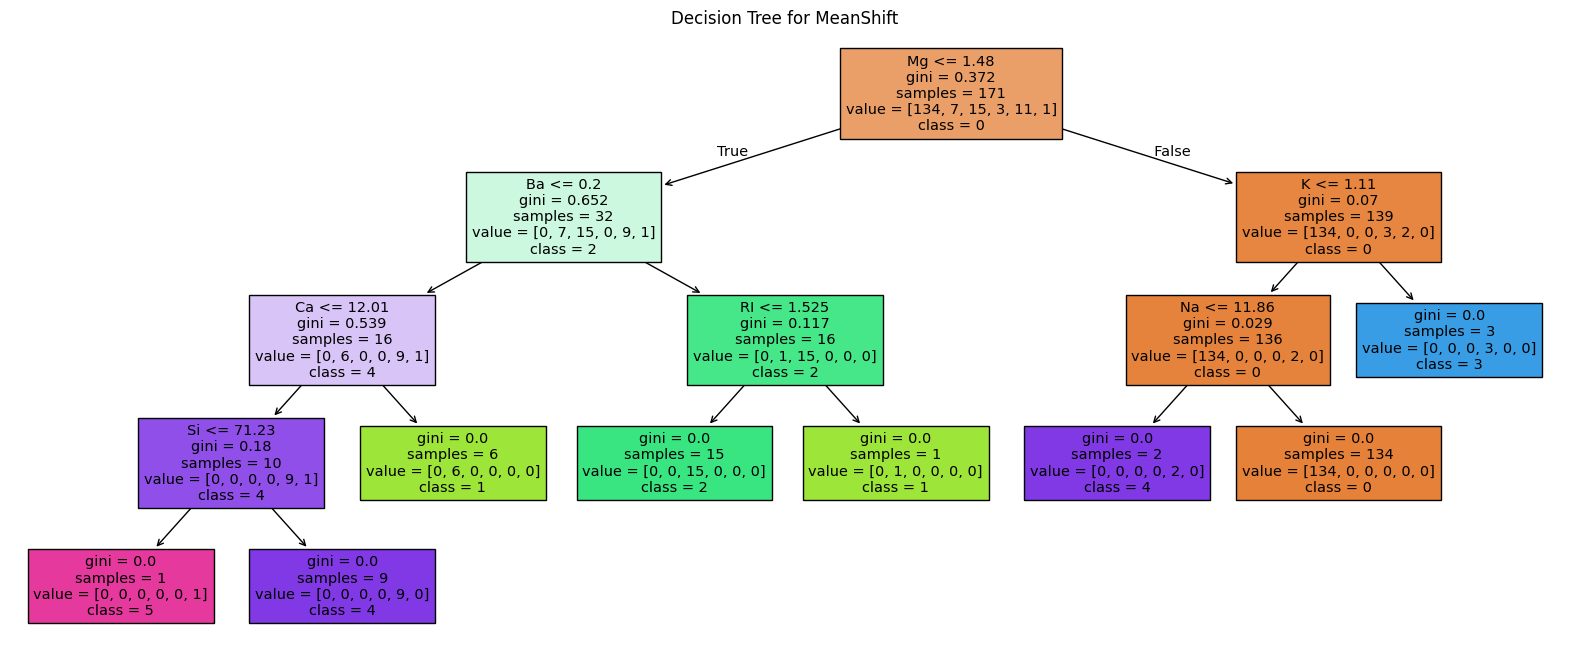

In [20]:
print('Decision Tree:')
plt.figure(figsize=(20, 8))
sk_tree.plot_tree(models['dtree'], filled=True, feature_names=glass.columns, class_names=np.unique(top_3_labels[top_3_algorithms.index[1]]).astype(str))
plt.title(f'Decision Tree for {top_3_algorithms.index[0]}')
plt.show()

In [21]:
print('DSGD Rules:')
models['ds'].print_most_important_rules(threshold=0.32)
print('--' * 40)

DSGD Rules:


Most important rules for class 0

	[0.749] R30: 0.173 < Ba < 0.520
			0: 0.614	1: 0.000	2: 0.300	3: 0.000	4: 0.000	5: 0.000	Unc: 0.086

	[0.626] R16: Si < 72.078
			0: 0.451	1: 0.299	2: 0.000	3: 0.042	4: 0.000	5: 0.076	Unc: 0.132

	[0.622] R24: Ca < 7.989
			0: 0.389	1: 0.000	2: 0.000	3: 0.422	4: 0.000	5: 0.181	Unc: 0.007

	[0.556] R2: 1.518 < RI < 1.521
			0: 0.425	1: 0.112	2: 0.000	3: 0.000	4: 0.190	5: 0.000	Unc: 0.273

	[0.550] R7: Na > 13.899
			0: 0.302	1: 0.000	2: 0.278	3: 0.067	4: 0.353	5: 0.000	Unc: 0.000

	[0.540] R3: RI > 1.521
			0: 0.408	1: 0.150	2: 0.000	3: 0.000	4: 0.156	5: 0.000	Unc: 0.286

	[0.510] R4: Na < 12.873
			0: 0.345	1: 0.409	2: 0.000	3: 0.000	4: 0.000	5: 0.000	Unc: 0.246

	[0.491] R19: Si > 73.112
			0: 0.248	1: 0.055	2: 0.278	3: 0.000	4: 0.388	5: 0.000	Unc: 0.031

	[0.488] R0: RI < 1.516
			0: 0.337	1: 0.000	2: 0.299	3: 0.021	4: 0.000	5: 0.049	Unc: 0.293

	[0.482] R21: 0.124 < K < 0.500
			0: 0.336	1: 0.009	2: 0.000	3: 0.000	4: 0.348	5: 0.000	Un

# Tercer algoritmo

In [22]:
#interpretamos primer algoritmo
models = saved_models[top_3_algorithms.index[2]]
print('Ripper Rules:')
models['ripper'].print_rules()

Ripper Rules:

Reglas para clase: 0
[[RI=<1.5159^Si=<71.76]]

Reglas para clase: 1
[[RI=1.5174-1.5178] V [Al=1.44-1.54] V [Al=1.23-1.29] V [Mg=3.49-3.54] V [Mg=3.15-3.43^Ba=<0.56] V [Na=12.86-13.0] V [Mg=3.43-3.49] V [Al=1.29-1.35] V [K=0.52-0.56] V [K=0.62-0.68]]

Reglas para clase: 2
[[Ca=9.57-10.09] V [Ca=9.02-9.57^Mg=>3.8] V [Mg=1.74-3.15^Al=1.54-1.69]]

Reglas para clase: 3
[[Mg=<1.74^Ba=>0.56] V [Mg=<1.74^RI=1.5159-1.5164] V [RI=<1.5159^Mg=<1.74]]

Reglas para clase: 4
[[Ca=>10.09^RI=1.5187-1.5206] V [Ca=>10.09^RI=1.5206-1.5221] V [Ca=>10.09^Si=>73.27]]

Reglas para clase: 5
[[Na=<12.72^RI=>1.5221]]


Decision Tree:


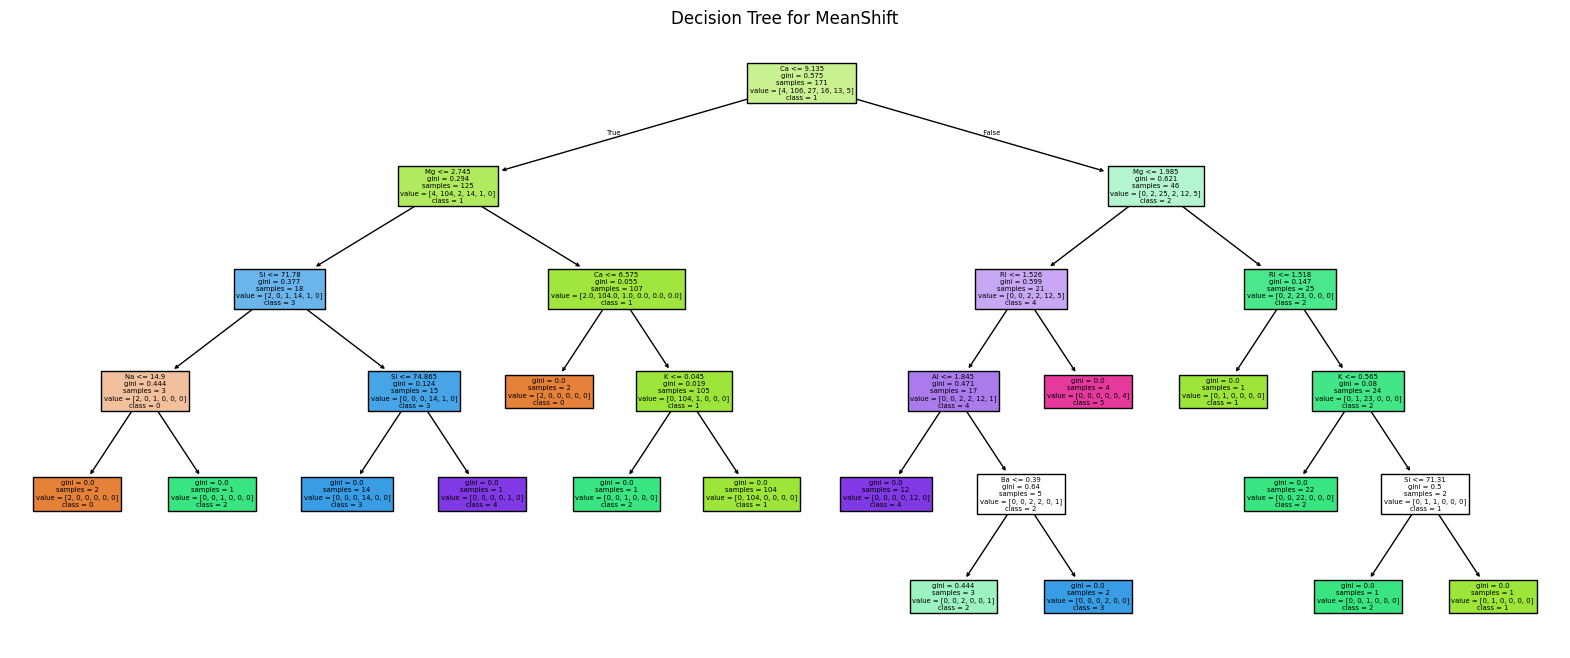

In [23]:
print('Decision Tree:')
plt.figure(figsize=(20, 8))
sk_tree.plot_tree(models['dtree'], filled=True, feature_names=glass.columns, class_names=np.unique(top_3_labels[top_3_algorithms.index[2]]).astype(str))
plt.title(f'Decision Tree for {top_3_algorithms.index[0]}')
plt.show()

In [24]:
print('DSGD Rules:')
models['ds'].print_most_important_rules(threshold=0.32)
print('--' * 40)

DSGD Rules:


Most important rules for class 0

	[0.726] R24: Ca < 7.989
			0: 0.527	1: 0.362	2: 0.000	3: 0.110	4: 0.000	5: 0.000	Unc: 0.001

	[0.724] R23: K > 0.877
			0: 0.524	1: 0.000	2: 0.000	3: 0.029	4: 0.446	5: 0.000	Unc: 0.000

	[0.581] R16: Si < 72.078
			0: 0.346	1: 0.248	2: 0.373	3: 0.000	4: 0.000	5: 0.008	Unc: 0.024

	[0.564] R31: Ba > 0.520
			0: 0.318	1: 0.100	2: 0.024	3: 0.395	4: 0.000	5: 0.161	Unc: 0.002

	[0.503] R0: RI < 1.516
			0: 0.273	1: 0.381	2: 0.000	3: 0.275	4: 0.000	5: 0.000	Unc: 0.071

	[0.455] R15: Al > 1.739
			0: 0.244	1: 0.091	2: 0.198	3: 0.314	4: 0.000	5: 0.000	Unc: 0.152

	[0.437] R9: 1.867 < Mg < 2.795
			0: 0.218	1: 0.000	2: 0.438	3: 0.000	4: 0.221	5: 0.000	Unc: 0.123

Most important rules for class 1

	[0.647] R19: Si > 73.112
			0: 0.000	1: 0.431	2: 0.000	3: 0.298	4: 0.244	5: 0.000	Unc: 0.027

	[0.620] R11: Mg > 3.724
			0: 0.000	1: 0.501	2: 0.266	3: 0.000	4: 0.000	5: 0.000	Unc: 0.233

	[0.615] R2: 1.518 < RI < 1.521
			0: 0.000	1: 0.398	2: 0.186	3: 